In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras import Input
from keras.layers import Dense, Flatten

import utils
from environment import RULEnvironment
from agent2 import MyAgent

### Load and preprocess train data

In [3]:
# Config
figsize = (9, 3)

In [4]:
data_path = "./data"
data = utils.load_data(data_path)
data.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD001,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,train_FD001,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,train_FD001,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,train_FD001,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,train_FD001,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [5]:
# Last column is the RUL (Label)
dt_in = list(data.columns[3:-1])
data[dt_in].describe()

,p1,p2,p3,s1,s2,s3,s4,s5,s6,s7,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,...,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000
mean,17.211973,0.410004,95.724344,485.840890,597.361022,1467.035653,1260.956434,9.894999,14.424935,359.729968,...,338.789821,2349.645243,8088.950972,9.054747,0.025185,360.698801,2273.754039,98.389146,25.942709,15.565700
std,16.527988,0.367938,12.359044,30.420388,42.478516,118.175261,136.300073,4.265554,6.443922,174.133835,...,164.193480,111.167242,80.623257,0.751581,0.004997,31.021430,142.513114,4.656270,11.691422,7.015067
min,-0.008700,-0.000600,60.000000,445.000000,535.480000,1242.670000,1023.770000,3.910000,5.670000,136.170000,...,128.310000,2027.570000,7845.780000,8.156300,0.020000,302.000000,1915.000000,84.930000,10.160000,6.010500
25%,0.001300,0.000200,100.000000,449.440000,549.960000,1357.360000,1126.830000,5.480000,8.000000,175.710000,...,164.790000,2387.970000,8070.530000,8.439250,0.020000,332.000000,2212.000000,100.000000,14.330000,8.601300
50%,19.998100,0.620000,100.000000,489.050000,605.930000,1492.810000,1271.740000,9.350000,13.660000,341.690000,...,321.690000,2388.070000,8118.590000,9.030100,0.030000,367.000000,2319.000000,100.000000,24.920000,14.953500
75%,35.001500,0.840000,100.000000,518.670000,642.340000,1586.590000,1402.200000,14.620000,21.610000,553.290000,...,521.340000,2388.160000,8139.410000,9.344200,0.030000,392.000000,2388.000000,100.000000,38.820000,23.294600
max,42.008000,0.842000,100.000000,518.670000,645.110000,1616.910000,1441.490000,14.620000,21.610000,570.810000,...,537.490000,2390.490000,8293.720000,11.066900,0.030000,400.000000,2388.000000,100.000000,39.890000,23.950500


In [6]:
# Check for null-values
data[dt_in].isnull().any().any()

# No null values

False

In [7]:
# Standardize all the daa-columns
data_sv = data.copy()
data_sv[dt_in] = (data_sv[dt_in] - data_sv[dt_in].mean()) / data_sv[dt_in].std()
data_sv.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD001,1,1,-1.041426,-1.115415,0.345954,1.079181,1.046623,1.037987,1.024530,...,0.345198,0.616063,-0.845214,0.963586,1.009019,0.801652,0.345954,1.121959,1.119490,191
1,train_FD001,1,2,-1.041268,-1.115143,0.345954,1.079181,1.054391,1.055926,1.043166,...,0.345648,0.527627,-0.828849,0.963586,1.009019,0.801652,0.345954,1.116827,1.120146,190
2,train_FD001,1,3,-1.041644,-1.113512,0.345954,1.079181,1.059100,1.023517,1.050943,...,0.345288,0.549209,-0.847476,0.963586,0.944547,0.801652,0.345954,1.112550,1.108828,189
3,train_FD001,1,4,-1.041341,-1.114327,0.345954,1.079181,1.059100,0.979514,1.033848,...,0.345738,0.556651,-0.913470,0.963586,1.009019,0.801652,0.345954,1.106563,1.113061,188
4,train_FD001,1,5,-1.041498,-1.114871,0.345954,1.079181,1.059570,0.980022,1.065763,...,0.345378,0.556279,-0.832042,0.963586,1.041254,0.801652,0.345954,1.108273,1.117409,187


In [8]:
data_sv_dict = utils.split_by_field(data_sv, field='src')
print('{{{}}}'.format(', '.join(f'{k}: ...' for k in data_sv_dict.keys())))

{train_FD001: ..., train_FD002: ..., train_FD003: ..., train_FD004: ...}


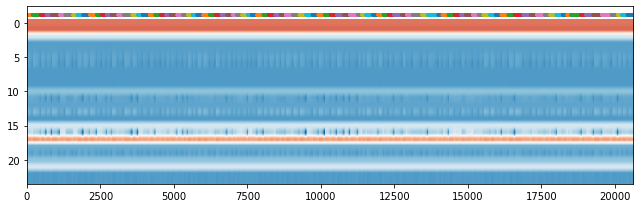

In [9]:
tmp = data_sv_dict['train_FD001']
utils.plot_dataframe(tmp[dt_in], labels=tmp['machine'], figsize=figsize)

### Make environment

In [10]:
env = RULEnvironment(data_sv, dt_in)

/Users/olestole/code/unibo/AI-industry/Turbine-RUL-RL/venv/lib/python3.7/site-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [11]:
states = env.observation_space.shape
actions = env.action_space.n
states

(24,)

### Build model

In [38]:
# def build_model(states, actions):
#     model = Sequential()
#     # model.add(Input((24))) 
#     model.add(Dense(24, activation='relu'))
#     model.add(Dense(64, activation='relu'))
#     model.add(Flatten(input_shape=(1,24)))
#     # model.add(Dense(24, activation='relu'))
#     model.add(Dense(2, activation='linear'))
#     return model

model = tf.keras.Sequential([
    tf.keras.layers.Dense(24, activation='relu', input_shape=(1,24)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='linear')
])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 1, 24)             600       
                                                                 
 dense_46 (Dense)            (None, 1, 64)             1600      
                                                                 
 flatten_12 (Flatten)        (None, 64)                0         
                                                                 
 dense_47 (Dense)            (None, 2)                 130       
                                                                 
Total params: 2,330
Trainable params: 2,330
Non-trainable params: 0
_________________________________________________________________


### Build agent

In [39]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = MyAgent(model=model, memory=memory, policy=policy, nb_actions=actions, nb_steps_warmup=5, target_model_update=1e-2)
    return dqn

In [41]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

### Train

In [42]:
nb_episodes = data_sv['machine'].max()
nb_steps = len(data_sv)

In [43]:
dqn.fit(env, nb_steps=nb_steps, nb_episodes=nb_steps, nb_max_episode_steps=None, visualize=False, verbose=1)

Training for 160359 steps ...
My methode is startn
e: 1 i 1
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 25:42 - reward: 1.0000e: 2 i 1
e: 3 i 1


/Users/olestole/code/unibo/AI-industry/Turbine-RUL-RL/venv/lib/python3.7/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/Users/olestole/code/unibo/AI-industry/Turbine-RUL-RL/venv/lib/python3.7/site-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


e: 4 i 1
    7/10000 [..............................] - ETA: 20:37 - reward: 1.0000e: 5 i 1
e: 6 i 1
e: 7 i 1
   11/10000 [..............................] - ETA: 13:19 - reward: 1.0000e: 8 i 1
e: 9 i 1
e: 10 i 1
   14/10000 [..............................] - ETA: 10:58 - reward: 1.0000e: 11 i 1
e: 12 i 1
e: 13 i 1
   17/10000 [..............................] - ETA: 9:27 - reward: 1.0000 e: 14 i 1
e: 15 i 1
   21/10000 [..............................] - ETA: 8:06 - reward: 1.0000e: 16 i 1
e: 17 i 1
   25/10000 [..............................] - ETA: 7:14 - reward: 1.0000e: 18 i 1
e: 19 i 1
   36/10000 [..............................] - ETA: 5:46 - reward: 1.0000e: 22 i 1
e: 23 i 1
   45/10000 [..............................] - ETA: 5:11 - reward: 1.0000e: 26 i 1
e: 27 i 1
   48/10000 [..............................] - ETA: 5:03 - reward: 1.0000e: 28 i 1
e: 29 i 1
e: 30 i 1
   51/10000 [..............................] - ETA: 4:56 - reward: 1.0000e: 31 i 1
e: 32 i 1
   54/10000 [.........

### Test

In [141]:
# Save and load the weights
def save_weights(dqn, nb_steps = 000):
    dqn.save_weights(f'./weights/dqn_{nb_steps}_weights.h5f', overwrite=True)

def load_weights(dqn, nb_steps = 000):
    dqn.load_weights(f'./weights/dqn_{nb_steps}_weights.h5f')

In [143]:
save_weights(dqn, nb_steps)

In [51]:
data_path = "./data"
data_test = utils.load_data(data_path, test=True)
dt_in_test = list(data_test.columns[3:-1])
data_test.describe()

# 707 machines
# Max amount of cycles: 486

,machine,cycle,p1,p2,p3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
count,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,...,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000
mean,372.662478,95.406589,17.243810,0.410887,95.748591,485.791314,597.153354,1464.738375,1257.240382,9.887805,...,2349.811235,8084.687648,9.046593,0.025039,360.088096,2273.841797,98.398282,25.949868,15.570426,94.406589
std,201.744654,74.311486,16.530141,0.368078,12.328151,30.426804,42.430629,117.856835,135.728855,4.265536,...,110.890533,78.956087,0.748390,0.005000,30.932463,142.218102,4.644631,11.701010,7.020590,74.311486
min,1.000000,1.000000,-0.008700,-0.000600,60.000000,445.000000,535.410000,1240.940000,1024.900000,3.910000,...,2027.740000,7849.800000,8.198000,0.020000,302.000000,1915.000000,84.930000,10.180000,6.123100,0.000000
25%,197.000000,38.000000,0.001300,0.000200,100.000000,449.440000,549.780000,1355.140000,1124.030000,5.480000,...,2387.950000,8068.360000,8.425600,0.020000,331.000000,2212.000000,100.000000,14.340000,8.607300,37.000000
50%,390.000000,80.000000,19.998200,0.620000,100.000000,489.050000,605.530000,1490.160000,1262.850000,9.350000,...,2388.050000,8113.100000,9.108500,0.030000,367.000000,2319.000000,100.000000,24.780000,14.872400,79.000000
75%,544.000000,135.000000,35.001500,0.840000,100.000000,518.670000,642.200000,1584.810000,1399.460000,14.620000,...,2388.110000,8136.630000,9.333900,0.030000,392.000000,2388.000000,100.000000,38.880000,23.331000,134.000000
max,707.000000,486.000000,42.008000,0.842000,100.000000,518.670000,644.320000,1609.690000,1434.120000,14.620000,...,2389.960000,8243.100000,11.030000,0.030000,398.000000,2388.000000,100.000000,39.750000,23.849600,485.000000


In [52]:
# Check for null-values
data_test[dt_in_test].isnull().any().any()

# No null values

False

In [54]:
# Standardize all the daa-columns
data_sv_test = data_test.copy()
data_sv_test[dt_in_test] = (data_sv_test[dt_in_test] - data_sv_test[dt_in_test].mean()) / data_sv_test[dt_in_test].std()
data_sv_test.describe()

,machine,cycle,p1,p2,p3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
count,104897.000000,104897.000000,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,...,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,104897.000000
mean,372.662478,95.406589,8.670360e-18,1.300554e-16,2.460215e-16,-1.929155e-15,-5.505678e-16,-1.140152e-15,-1.586676e-15,-2.731163e-16,...,2.991274e-15,-7.495526e-15,9.190581e-16,-1.764418e-15,-7.066343e-16,1.486967e-15,4.324342e-16,-3.121329e-16,6.762880e-16,94.406589
std,201.744654,74.311486,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,74.311486
min,1.000000,1.000000,-1.043700e+00,-1.117934e+00,-2.899753e+00,-1.340638e+00,-1.455160e+00,-1.898900e+00,-1.711798e+00,-1.401419e+00,...,-2.904407e+00,-2.974915e+00,-1.133891e+00,-1.007737e+00,-1.877901e+00,-2.523179e+00,-2.899753e+00,-1.347736e+00,-1.345660e+00,0.000000
25%,197.000000,38.000000,-1.043095e+00,-1.115760e+00,3.448537e-01,-1.194714e+00,-1.116490e+00,-9.299280e-01,-9.814448e-01,-1.033353e+00,...,3.439317e-01,-2.067940e-01,-8.297717e-01,-1.007737e+00,-9.403744e-01,-4.348377e-01,3.448537e-01,-9.922108e-01,-9.918149e-01,37.000000
50%,390.000000,80.000000,1.666284e-01,5.681230e-01,3.448537e-01,1.070992e-01,1.974198e-01,2.156992e-01,4.132959e-02,-1.260814e-01,...,3.448334e-01,3.598500e-01,8.272022e-02,9.923125e-01,2.234515e-01,3.175278e-01,3.448537e-01,-9.998010e-02,-9.942553e-02,79.000000
75%,544.000000,135.000000,1.074261e+00,1.165823e+00,3.448537e-01,1.080583e+00,1.061654e+00,1.018792e+00,1.047822e+00,1.109402e+00,...,3.453745e-01,6.578638e-01,3.839000e-01,9.923125e-01,1.031664e+00,8.026981e-01,3.448537e-01,1.105044e+00,1.105402e+00,134.000000
max,707.000000,486.000000,1.498123e+00,1.171256e+00,3.448537e-01,1.080583e+00,1.111618e+00,1.229896e+00,1.303184e+00,1.109402e+00,...,3.620576e-01,2.006335e+00,2.650231e+00,9.923125e-01,1.225635e+00,8.026981e-01,3.448537e-01,1.179397e+00,1.179270e+00,485.000000


In [55]:
env_test = RULEnvironment(data_sv_test, dt_in_test)

/Users/olestole/code/unibo/AI-industry/Turbine-RUL-RL/venv/lib/python3.7/site-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [56]:
nb_episodes = data_sv_test['machine'].max()

In [57]:
scores = dqn.test(env_test, nb_episodes=nb_episodes, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 707 episodes ...
e: 1 i 1
Episode 1: reward: -456.000, steps: 30
e: 2 i 1
Episode 2: reward: -438.000, steps: 48
e: 3 i 1
Episode 3: reward: -361.000, steps: 125
e: 4 i 1
Episode 4: reward: -381.000, steps: 105
e: 5 i 1
Episode 5: reward: -389.000, steps: 97
e: 6 i 1
Episode 6: reward: -382.000, steps: 104
e: 7 i 1
Episode 7: reward: -327.000, steps: 159
e: 8 i 1
Episode 8: reward: -321.000, steps: 165
e: 9 i 1
Episode 9: reward: -432.000, steps: 54
e: 10 i 1
Episode 10: reward: -295.000, steps: 191
e: 11 i 1
Episode 11: reward: -404.000, steps: 82
e: 12 i 1
Episode 12: reward: -270.000, steps: 216
e: 13 i 1
Episode 13: reward: -292.000, steps: 194
e: 14 i 1
Episode 14: reward: -441.000, steps: 45
e: 15 i 1
Episode 15: reward: -411.000, steps: 75
e: 16 i 1
Episode 16: reward: -374.000, steps: 112
e: 17 i 1
Episode 17: reward: -322.000, steps: 164
e: 18 i 1
Episode 18: reward: -354.000, steps: 132
e: 19 i 1
Episode 19: reward: -352.000, steps: 134
e: 20 i 1
Episode 20: rewar

In [140]:
scores.history['episode_reward']
machines = data_sv_test['machine'].unique()

def print_scores(scores):
    for i, history in enumerate(zip(scores.history['nb_steps'], scores.history['episode_reward'])):
        cycles = data_sv_test.loc[data_sv_test['machine'] == i + 1][['rul']].max().item()
        print(f"{i}:\tMachine-cycles: {cycles}\tSteps: {history[0]}\t Reward: {history[1]}")

print_scores(scores)

0:	Machine-cycles: 30	Steps: 30	 Reward: -456.0
1:	Machine-cycles: 48	Steps: 48	 Reward: -438.0
2:	Machine-cycles: 125	Steps: 125	 Reward: -361.0
3:	Machine-cycles: 105	Steps: 105	 Reward: -381.0
4:	Machine-cycles: 97	Steps: 97	 Reward: -389.0
5:	Machine-cycles: 104	Steps: 104	 Reward: -382.0
6:	Machine-cycles: 159	Steps: 159	 Reward: -327.0
7:	Machine-cycles: 165	Steps: 165	 Reward: -321.0
8:	Machine-cycles: 54	Steps: 54	 Reward: -432.0
9:	Machine-cycles: 191	Steps: 191	 Reward: -295.0
10:	Machine-cycles: 82	Steps: 82	 Reward: -404.0
11:	Machine-cycles: 216	Steps: 216	 Reward: -270.0
12:	Machine-cycles: 194	Steps: 194	 Reward: -292.0
13:	Machine-cycles: 45	Steps: 45	 Reward: -441.0
14:	Machine-cycles: 75	Steps: 75	 Reward: -411.0
15:	Machine-cycles: 112	Steps: 112	 Reward: -374.0
16:	Machine-cycles: 164	Steps: 164	 Reward: -322.0
17:	Machine-cycles: 132	Steps: 132	 Reward: -354.0
18:	Machine-cycles: 134	Steps: 134	 Reward: -352.0
19:	Machine-cycles: 183	Steps: 183	 Reward: -303.0
20:	